###### feature set 8 chromosomes 5, 6, 7 + unknown

## In this notebook:

* single input dataframe 
* using feature set 8
* random forest
* only training/test split, no epochs 
* aucuracy assessement of RF:  0.76
* feature importance for RF (mostly just amino acid position)

In [7]:
import torch
import pandas as pd
import numpy as np

# using sklearn goodies
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split


## pull in pickled dataframe:
df = pd.read_pickle("./pickled/chr5-7_unk_featureset8.pkl")



print("shape before", df.shape)
df = df.replace({'.': 0})  ## FIXME: atm replace with nan and drop: later find a way to impute, maybe 0 but not sure
#print("SUM", pd.isnull(df).sum())  ## Use this to see how many elements have nan 
df = df.dropna()
print("shape after dropping all data with score = '.'", df.shape)
#print(df.head())

## still contains some mixed labels, see them by: df[~df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]


#df.head()
#df = df[df['clinvar_clnsig'].isin(list(clinvar_labels.keys()))]  # best to drop everything that isn't in the dict
#df['Problematic'] = df['clinvar_clnsig'].map(clinvar_labels)

#df= df.drop(columns=['clinvar_clnsig'])#, 'clinvar_id'])  #tbh, I don't know why I kept them. consider adding to index

df = df.replace({'-': 0}) 
print("shape after dropping Unk", df.shape)
df.head()

### pickle to reuse dataframe:
#df.to_pickle("./pickled_df/all_scores_chr18,20.pkl")


shape before (27056, 15)
shape after dropping all data with score = '.' (27056, 15)
shape after dropping Unk (27056, 15)


aapos codonpos MutationTaster_score  \
chr pos    ref alt                                        
5   156173 C   T      415        1             0.999355   
    161930 G   A      523        1                    1   
    171224 G   A     1277        2             0.999839   
    218356 A   C        1        1                    1   
               G        1        1                    1   

                   fathmm-XF_coding_score   GenoCanyon_score LINSIGHT  \
chr pos    ref alt                                                      
5   156173 C   T                 0.159257  0.999569756240283        0   
    161930 G   A                 0.056152  0.999986473921774        0   
    171224 G   A                 0.038730  0.999641967193416        0   
    218356 A   C                 0.026135  0.999999986478772        0   
               G                 0.022498  0.999999986478772        0   

                       RVIS_ExAC     ExAC_cnv.score  \
chr pos    ref alt                                    
5   156173 C   T     2.023530538  -2.47162789907313   
    161930 G   A     2.023530538  -2.47162789907313   
    171224 G   A     2.023530538  -2.47162789907313   
    218356 A   C    -0.651593635  -2.47162789907313   
               G    -0.651593635  -2.47162789907313   

                    SORVA_LOF_MAF0.005_HetOrHom  Problematic  Mutation<1kb  \
chr pos    ref alt                                                           
5   156173 C   T                       0.002396            0             1   
    161930 G   A                       0.002396            2             1   
    171224 G   A                       0.002396            2             1   
    218356 A   C                       0.000799            1            18   
               G                       0.000799            1            18   

                    Mutation<5kb  Mutation<10kb  Mutation<30kb  Mutation<100kb  
chr pos    ref alt                                                              
5   156173 C   T               1              2              3             373  
    161930 G   A               1              3              3             409  
    171224 G   A               1              2             10             409  
    218356 A   C              18            128            289             409  
               G              18            128            289             409

In [8]:
## Split into train/test
data_copy = df.copy()
df_train = data_copy.sample(frac=0.75, random_state=1)
df_test = data_copy.drop(df_train.index)

print ('Training data subset\n')
print (df_train.head(3))  # head default n=5, first 3 is enough
print ('\nTest data subset\n')
print (df_test.head(3))


## Get label:
train_labels = df_train.pop('Problematic')  # replace with clinvar when column is available
test_labels = df_test.pop('Problematic')

Training data subset

                       aapos codonpos MutationTaster_score  \
chr pos       ref alt                                        
6   7581403   G   A     1738        2                    1   
    109481980 G   C       16        2                    1   
7   21616269  G   A     1358        1             0.999485   

                      fathmm-XF_coding_score   GenoCanyon_score LINSIGHT  \
chr pos       ref alt                                                      
6   7581403   G   A                 0.250587                  1        0   
    109481980 G   C                 0.124290                  1        0   
7   21616269  G   A                 0.163289  0.999987109177751        0   

                          RVIS_ExAC      ExAC_cnv.score  \
chr pos       ref alt                                     
6   7581403   G   A    -1.944229704   0.857032489910083   
    109481980 G   C    -0.857788844    0.48277468315444   
7   21616269  G   A     5.585496797  -0.1598935940

Confusion matrix: 
 [[3969  302   86]
 [ 594 1039   12]
 [ 570   40   97]]
Accuracy: 0.7609181696228946
Recall TP/(TP+FN): [0.9109479  0.63161094 0.13719943]
Precision TP/(TP+FP): [0.77323203 0.75235337 0.4974359 ]
F1: [0.83645943 0.68671514 0.21507761]
Feature ranking:
1. feature 3 (0.163307)
fathmm-XF_coding_score
2. feature 0 (0.115786)
aapos
3. feature 2 (0.104875)
MutationTaster_score
4. feature 4 (0.077947)
GenoCanyon_score
5. feature 13 (0.072843)
Mutation<100kb
6. feature 12 (0.072839)
Mutation<30kb
7. feature 11 (0.064276)
Mutation<10kb
8. feature 6 (0.063913)
RVIS_ExAC
9. feature 9 (0.062715)
Mutation<1kb
10. feature 10 (0.062572)
Mutation<5kb
11. feature 7 (0.052030)
ExAC_cnv.score
12. feature 1 (0.040010)
codonpos
13. feature 8 (0.032026)
SORVA_LOF_MAF0.005_HetOrHom
14. feature 5 (0.014862)
LINSIGHT


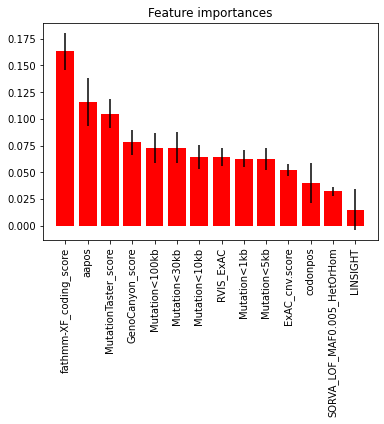

In [9]:
# Try a random forest:

from sklearn.ensemble import RandomForestClassifier
# forest = RandomForestClassifier(random_state=1, class_weight="balanced")
forest = RandomForestClassifier(n_estimators=1000, random_state=42, class_weight="balanced")
forest.fit(df_train, train_labels)
#ax = plt.gca()
#rfc_disp = plot_roc_curve(forest, df_test, test_labels, ax=ax, alpha=0.8)
#svc_disp.plot(ax=ax, alpha=0.8) ## if you want to plot both svm and rf
#plt.show()

## metrics:
y_true = test_labels.to_numpy()
y_pred = forest.predict(df_test)

# Confusion Matrix
from sklearn.metrics import confusion_matrix
print("Confusion matrix: \n", confusion_matrix(y_true, y_pred))

# Accuracy
from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_true, y_pred))

# Recall
from sklearn.metrics import recall_score
recall = recall_score(y_true, y_pred, average=None)
print("Recall TP/(TP+FN):", recall)

# Precision
from sklearn.metrics import precision_score
precision = precision_score(y_true, y_pred, average=None)
print("Precision TP/(TP+FP):",precision)


# F1 score
F1 = 2 * (precision * recall) / (precision + recall)
print("F1:", F1)

## Get at and plot the feature importance (tutorial: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
feature_labels = list(df_train) # columns names
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(df_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
    print(feature_labels[indices[f]])

    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_train.shape[1]), labels=df_train.columns[indices], rotation=90)
plt.xlim([-1, df_train.shape[1]])
plt.show()

In [10]:
print(df_test, y_pred)

                       aapos codonpos MutationTaster_score  \
chr pos       ref alt                                        
5   218360    C   T        2        2             0.998408   
    218378    C   G        8        2             0.999987   
    218380    C   G        9        1             0.999997   
    218407    C   G       18        1                    1   
    218416    G   A       21        1                    1   
...                      ...      ...                  ...   
7   158887076 G   A       -1        0                    1   
    158906001 C   A      457        2             0.999999   
    158914251 C   T      574        2                    1   
    158923584 G   T      703        2             0.999998   
    158945655 C   T     1026        2                    1   

                      fathmm-XF_coding_score   GenoCanyon_score  LINSIGHT  \
chr pos       ref alt                                                       
5   218360    C   T                 0.1